# Shape Atlas Viewer 
Portions of plotting code adapted from Allen Cell Institute python code

https://www.allencell.org/cell-shape-analysis.html

https://github.com/AllenCellModeling/AllenCellModeling.github.io


In [37]:
# Import modules
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import seaborn
seaborn.set_context('notebook')
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import ipywidgets as widgets
from IPython.display import display, clear_output

### Load PCA data from .mat


In [60]:
pca_mat_ed = sio.loadmat('/Users/Nick/Documents/UCSD/CAP/CIM/Matlab/PCATool_v2/PCA_ED.mat')
PCA_ED = pca_mat_ed['PCA_ED']
pca_mat_es = sio.loadmat('/Users/Nick/Documents/UCSD/CAP/CIM/Matlab/PCATool_v2/PCA_ES.mat')
PCA_ES = pca_mat_es['PCA_ES']

def choose_atlas(spec):
    if spec == 1:
        # set ED atlas
        coeff = PCA_ED['COEFF']
        coeff = coeff[0][0]
        scores = PCA_ED['SCORE']
        scores = scores[0][0]
        latent = PCA_ED['LATENT']
        latent = latent[0][0]
        mean = PCA_ED['MEAN']
        mean = mean[0][0]
        return coeff, scores, latent, mean
    elif spec == 2:
        # set ES atlas
        coeff = PCA_ES['COEFF']
        coeff = coeff[0][0]
        scores = PCA_ES['SCORE']
        scores = scores[0][0]
        latent = PCA_ES['LATENT']
        latent = latent[0][0]
        mean = PCA_ES['MEAN']
        mean = mean[0][0]
        return coeff, scores, latent, mean

face_mat = sio.loadmat('/Users/Nick/Documents/UCSD/CAP/CIM/Matlab/PCATool_v2/SurfaceFaces.mat')
faces = face_mat['Face']
face_endo = faces['Endo']
face_endo = face_endo[0][0]-1
face_epi = faces['Epi']
face_epi = face_epi[0][0]-1
faces_all = np.concatenate((face_endo,face_epi),axis=0)

### Define atlas shape function

In [39]:
def get_atlas_shape(mode, zscore, coeff, scores, latent, mean):
    if mode < 1:
        print('Mode must be between 1 and %d' % len(latent))
    else:
        d = zscore * np.sqrt(latent[mode-1])
        P_1d = mean + d*coeff[:,mode-1].T
        P_3d = np.reshape(P_1d, (-1,3))
        # Rotate points
        theta = np.radians(90)
        c,s = np.cos(theta), np.sin(theta)
        Rx = np.array(((1,0,0),(0,c,s),(0,-s,c)))
        Ry = np.array(((c,0,-s),(0,1,0),(s,0,c)))
        Rz = np.array(((c,s,0),(-s,c,0),(0,0,1)))
        P = np.dot(P_3d, Ry)
        return P

### Define volume plot function

In [175]:
def plot_volume_widget(atlas,mode,z,surf,rot,ax):
    coeff, scores, latent, mean = choose_atlas(atlas)
    P = get_atlas_shape(mode, z, coeff, scores, latent, mean)

    if surf == 1: #epi
        P_plot = P[841:1683,:]
        face_plot = face_endo
    elif surf == 2: #endo
        P_plot = P[0:841,:]
        face_plot = face_endo
    elif surf == 3: #both
        P_plot = P
        face_plot = faces_all
    
    x, y, z = P_plot.T
    ax.clear()
    ax.plot_trisurf(x, y, face_plot, z, 
                    lw=0, 
#                     cmap=plt.cm.Paired,
#                     color=plt.cm.Reds(0.9),
                    alpha=0.5,
                    edgecolors='k',
                    antialiased=False
                   )
    
    xmin,xmax = -50, 50
    ymin,ymax = -50, 50
    zmin,zmax = -50, 50
    
    ax.set_axis_off()
    ax.view_init(20,rot)
    ax.dist = 10     # how far from axis we want to be
    ax.elev = 20
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((ymin,ymax))
    ax.set_zlim((zmin,zmax))
    ax.set(aspect='equal', 
           facecolor="white")
    with out:
        clear_output(wait=True)
        display(fig)

def plot_volume(verts,faces,ax,zoom=8):
    x, y, z = verts.T
    ax.plot_trisurf(x, y, faces, z, lw=0, 
#                     cmap=plt.cm.Paired, 
                    alpha=0.6)
    ax.set_axis_off()  # look nice with no axes 
    ax.dist = 8    # how far from axis we want to be
    ax.set(aspect='equal', 
           facecolor="white")
    ax.set_title('z')
    

### Create widgets

In [178]:
score_slider = widgets.FloatSlider(
    value= 0,
    min=-5,
    max=5,
    step=0.1,
    readout_format='.1f',
    description='z-score:'
)

mode_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='Mode:',
)

surface_select = widgets.Dropdown(
    options={'Epi':1,'Endo':2,'Epi + Endo':3},
    value = 3,
    description='Surface:'
)

atlas_select = widgets.Dropdown(
    options={'ED atlas':1,'ES atlas':2},
    value = 1,
    description='Choose atlas:'
)

rotate_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=360,
    step=45,
    description='Rotation:'
)

button = widgets.Button(
    description='Show',
)

# out = widgets.Output(layout=widgets.Layout(align_items='stretch',width='70%'))
out = widgets.Output()

#define functions to respond to widgets
def on_mode_change(change):
    plot_volume_widget(atlas_select.value, change['new'], score_slider.value, 
                       surface_select.value, rotate_slider.value,ax)
def on_score_change(change):
    plot_volume_widget(atlas_select.value, mode_slider.value, change['new'], 
                       surface_select.value, rotate_slider.value, ax)
def on_surf_change(change):
    plot_volume_widget(atlas_select.value, mode_slider.value, score_slider.value, 
                       change['new'], rotate_slider.value, ax)
def on_rotate_change(change):
    plot_volume_widget(atlas_select.value, mode_slider.value, score_slider.value, 
                       surface_select.value, change['new'], ax)
def on_atlas_change(change):
    plot_volume_widget(change['new'], mode_slider.value, score_slider.value, 
                       surface_select.value, rotate_slider.value, ax)

### PLOT Individual Mode Shape

In [180]:
plt.rcParams['figure.figsize'] = [60, 60]

score_slider.observe(on_score_change,names='value')
mode_slider.observe(on_mode_change,names='value')
surface_select.observe(on_surf_change,names='value')
rotate_slider.observe(on_rotate_change,names='value')
atlas_select.observe(on_atlas_change,names='value')

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.close(fig)

vbox_layout = widgets.Layout(
                    display='flex',
                    flex_flow='column',
                    align_items='center',
#                     border='solid',
#                     width='30%'
)


hbox_layout = widgets.Layout(
                    display='flex',
                    flex_flow='row',
                    align_items='center',
#                     border='solid',
)

vbox = widgets.VBox(children=(atlas_select,mode_slider,score_slider,surface_select,rotate_slider),layout=vbox_layout)
hbox = widgets.HBox(children=(out,vbox),layout=hbox_layout)
display(hbox)

#initialize plot
coeff, scores, latent, mean = load_atlas(1)
plot_volume_widget(atlas_select.value, mode_slider.value, score_slider.value, surface_select.value, 
                   rotate_slider.value, ax)

### PLOT Mutiple Mode Shapes

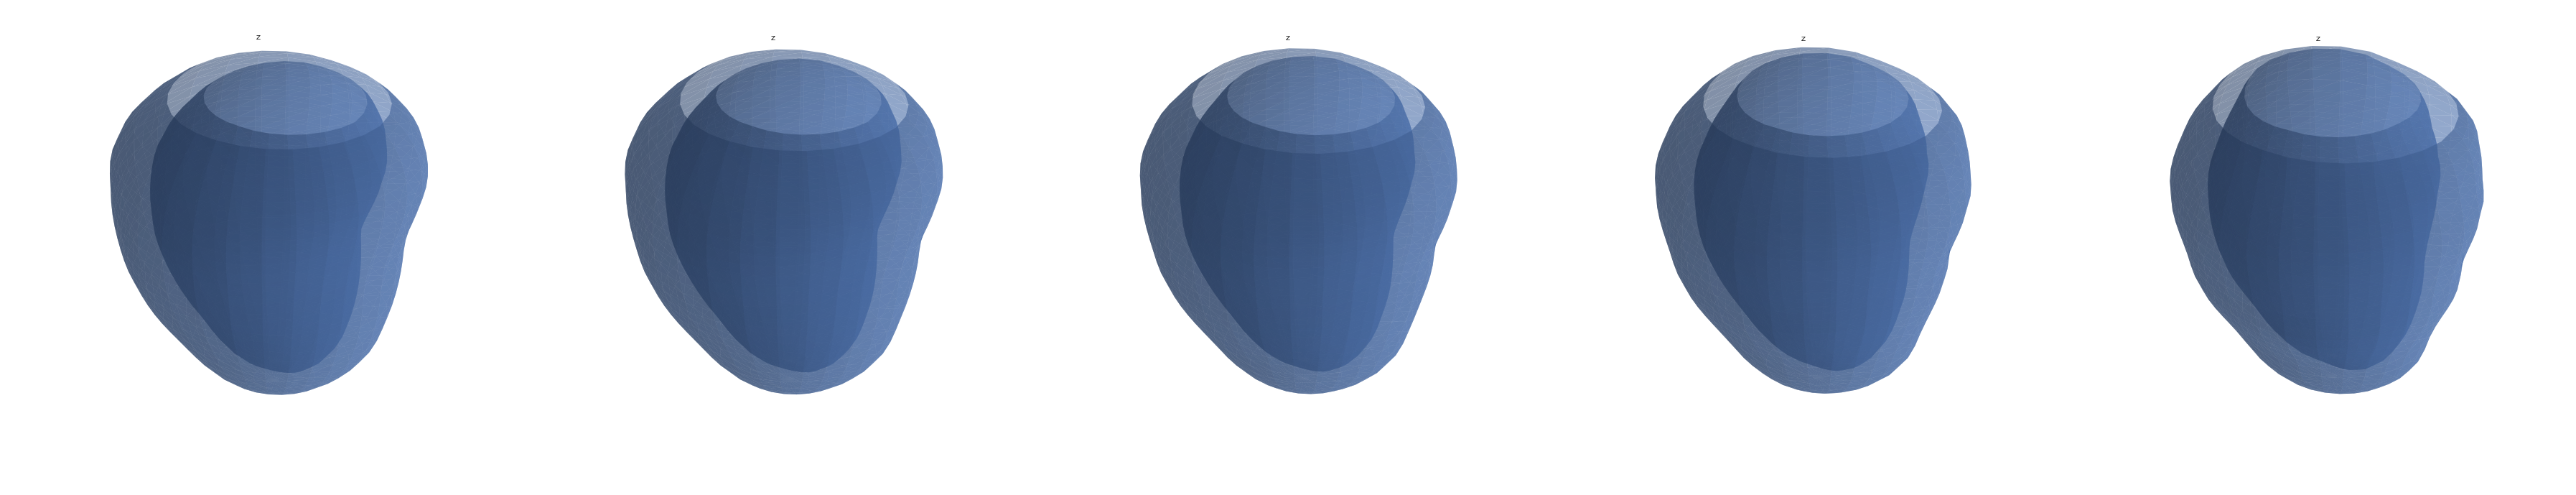

In [151]:
# Which atlas
atlas = 1 # ED
# atlas = 2 # ES
coeff, scores, latent, mean = choose_atlas(atlas)

# Set mode
mode = 1

# Set z-scores
z = [-4,-2,0,2,4]
n = len(z)

fig, axes = plt.subplots(1, n, 
                         #figsize=(20,5),
                         subplot_kw={"projection":"3d"})

for i,ax in enumerate(axes):
    P = get_atlas_shape(mode, z[i], coeff, scores, latent, mean)
    P_endo = P[0:841,:]
    P_epi = P[841:1683,:]
    plot_volume(P, faces_all, ax)
plt.tight_layout()